# Oil Palm Probabilistic Risk Assessment

This notebook performs a probabilistic risk assessment of chemicals found in oil palm plantations.

## Setup

Load the required libraries and set some useful variables.

In [136]:
import numpy as np
from scipy import stats
from scipy import interpolate
import scipy.spatial.distance
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
rcParams_default = plt.rcParams.copy()
from ipywidgets import interact, widgets
from matplotlib.patches import Rectangle
import plotly.express as px

# Setting some important variables
compartments = ['water', 'soil']
units = {'water': 'μg/L', 'soil': 'mg/kg'}
n_iterations = 10000
# Minimum number of datapoints required to perform the
# assessment for a given chemical
min_n_tox_datapoints = 9
min_mec_datapoints = 3

# Run the data parsing notebook to import the parse_data function
%run ./data-parsing.ipynb

Install R packages and load the rpy2 extension. This only needs to be done once but might take quite a while - grab a coffee! If it stalls or the kernel dies, try restarting the kernel and running the cell again.

**If you encounter package not found errors whilst running the below cell, you might want to try forcibly removing any "00LOCK" folders in the R library folder. The location of these folders will depend on the machine you are running this notebook on, but if you are using Binder, then running the following command should work: `rm /srv/conda/envs/notebook/lib/R/library/00LOCK* -rf`.**

In [137]:
import rpy2.robjects.packages as rpackages
import rpy2.robjects.numpy2ri
from rpy2.robjects.vectors import StrVector

# Make NumPy work
rpy2.robjects.numpy2ri.activate()

# Import R's utility package
utils = rpackages.importr('utils')

# Select CRAN mirror for R packages
utils.chooseCRANmirror(ind=1)

# R package names
packnames = ('trapezoid', 'mc2d', 'ggplot2')

# Install the packages
utils.install_packages(StrVector(packnames))
    
%load_ext rpy2.ipython

R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/trapezoid_2.0-2.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 153188 bytes (149 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to co

x86_64-conda-linux-gnu-cc -I"/home/sharrison/miniconda3/envs/borneo/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/sharrison/miniconda3/envs/borneo/include -I/home/sharrison/miniconda3/envs/borneo/include -Wl,-rpath-link,/home/sharrison/miniconda3/envs/borneo/lib   -fpic  -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /home/sharrison/miniconda3/envs/borneo/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1671440533574/work=/usr/local/src/conda/r-base-4.2.2 -fdebug-prefix-map=/home/sharrison/miniconda3/envs/borneo=/usr/local/src/conda-prefix  -c trapezoid.c -o trapezoid.o
x86_64-conda-linux-gnu-cc -I"/home/sharrison/miniconda3/envs/borneo/lib/R/include" -DNDEBUG   -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /home/sharrison/miniconda3/envs/borneo/include -I/home/sharrison/miniconda3/envs/borneo/include -Wl,-rpath-link,/home/sharrison/miniconda3/envs/bor

** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (trapezoid)
* installing *source* package ‘ggplot2’ ...
** package ‘ggplot2’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** data
*** moving datasets to lazyload DB
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
*** copying figures
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (ggplot2)
* installing *source* packa

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Parse the data

We call the `parse_data` function from the [data-parsing.ipynb](./data-parsing.ipynb) notebook to load, clean and filter the data, ready for use in the risk assessment.

In [139]:
# Path to the files
mec_filepath = '../data/Appendix 2_ Application and Environmental concentrations from literature.xlsx'
tox_filepath = '../data/Appendix 1_ Median lethal concentrations aquatic and terrestrial species.xlsx'

# Parse the data
df_mec, df_tox = parse_data(mec_filepath, tox_filepath)

/tmp/ipykernel_14978/852082573.py:83: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



## Applying uncertainty factors

We now apply uncertainty factors to the data points:
- $U_{DD}$ - dose descriptor uncertainty factors converts a given dose descriptor to NOEC. [Wigger et al, 2019](https://doi.org/10.1002/ieam.4214) uses $U_{DD} = 10$ to convert LC50s to NOECs (See Table 3), which we will also use here.
- $U_t$ - correct for exposure duration to convert accute to chronic values. See [Wigger et al, 2019](https://doi.org/10.1002/ieam.4214) Table 2. As all of our exposures are accute, we will use $U_t = 10$.

Coefficients of variation are used to construct distributions. $CV_{DP}$ is used to account for interlaboratory variability. $CV_{UF}$ is used to account for uncertainty in using non-substance-specific uncertainty factors. Again, the same CV values as [Wigger et al, 2019](https://doi.org/10.1002/ieam.4214) are used here.

In [140]:
u_dd = 10
u_t = 10
cv_dp = 0.3
cv_uf = 0.5

# Correct the data using the uncertainty factors
for c in compartments:
    df_tox[c]['tox_conv'] = df_tox[c]['LC50'] / (u_dd * u_t)

## Grouping by chemical and species

We now group the data by chemical and species to get lists of chemicals and species to perform the assessment for.

In [141]:
mec_chem_names = {}
tox_chem_names = {}
species_names = {}
s_taxa = {}

# Get the list of chemical and species names for soils and waters
for c in compartments:
    # Get the list of taxa
    s_taxa[c] = df_tox[c]['Taxa'].drop_duplicates().reset_index(drop=True)
    # Get the list of chemical names with more than one row sorted by amount of data
    mec_gb = df_mec[c].groupby('chemical') \
                      .size() \
                      .sort_values(ascending=False)
    # Filter to include only chemicals that have more than the min number of MECs
    mec_gb = mec_gb[mec_gb >= min_mec_datapoints]
    # Get the names as an array
    mec_chem_names[c] = mec_gb.keys().values
    
    # Do the same for the tox data
    tox_gb = df_tox[c].groupby('Chemical') \
                      .agg(size=('tox_conv', 'count'),
                           nunique=('tox_conv', 'nunique')) \
                      .sort_values(ascending=False, by='size')
    # Filter to include only chemicals that have more than the min numbers of tox values
    tox_gb = tox_gb[(tox_gb['size'] >= min_n_tox_datapoints) & (tox_gb['nunique'] >= min_n_tox_datapoints)]
    # Get the names as an array
    tox_chem_names[c] = tox_gb.index.values
    
    
# Now get the common names across the MEC and tox data. This should retain the
# order from the MEC data
common_chem_names = {c: [name for name in mec_chem_names[c] if name in tox_chem_names[c]]
                     for c in compartments}
species_by_chemical = {'water': {}, 'soil': {}}

# Now for all chemicals, get the list of species that we have tox data for
for c in compartments:
    for chem in common_chem_names[c]:
        df_tox_chem = df_tox[c][df_tox[c]['Chemical'] == chem]
        df_species_gb = df_tox_chem.groupby('Species')['Species'].count()
        species_by_chemical[c][chem] = df_species_gb

## Sample a probability density function for each species

We use the same method as the PSSD+ approach from [Wigger et al, 2019](https://doi.org/10.1002/ieam.4214) to generate and sample probability distributions for each species. This builds triangular, trapezoidal or extended step distributions, depending on the number of data points for the particular species in question. Monte Carlo sampling is performed `n_iterations` times for each distribution.

First, we define a function (in R) that generates and samples the distributions. Internally, this function calls code from [https://doi.org/10.5281/zenodo.3516566](https://doi.org/10.5281/zenodo.3516566), contained in the [rmore.R](./rmore.R) file.

In [142]:
%%R -o generate_distribution

# Load the required libraries and the rmore function
library('trapezoid')
library('mc2d')
source('rmore.R')

generate_distribution <- function(values, cv_dp, cv_uf, N = 10000) {
    # Function that constructs and samples a distribution based on passed
    # data points. Adapted from doi:10.5281/zenodo.3516566.
    #
    # Params:
    #   values   The data points to generate the distribution from
    #   cv_dp    Coefficient of variation for interlaboratory variation
    #   cv_uf    Coefficient of variation for use of non-substance-specific uncertainty factors
    #   N        Number of samples to be taken from the distribution, default = 10,000
    
    # Sort the values in ascending order
    sort.values <- sort(values)
    
    # Calculate the min and max of the distribution using CV values
    sp.min <- values[which.min(values)] * (1 - (sqrt((cv_dp/2.45)^2 + (cv_uf/2.45)^2 + (cv_uf/2.45)^2) * 2.45))
    sp.max <- values[which.max(values)] * (1 + (sqrt((cv_dp/2.45)^2 + (cv_uf/2.45)^2 + (cv_uf/2.45)^2) * 2.45))
    
    # Create each a triangular, trapezoidal or extended distribution,
    # depending on how many datapoints there are
    if(length(values) == 1) {
        # Triangular distribution, if only one value
        dist <- rtrunc("rtriang",
                       min = sp.min,
                       mode = sort.values[1],
                       max = sp.max,
                       n = N, linf = 0)
    } else if(length(values) == 2) {
        # Trapezoidal distribution, if two values
        dist <- rtrunc("rtrapezoid", N,
                       mode1 = sort.values[1],
                       mode2 = sort.values[2],
                       min = sp.min, max = sp.max,
                       linf = 0)
    } else {
        # Extended step distribution, if three or more values
        dist <- rmore(values = values,
                      min = sp.min,
                      max = sp.max,
                      N = N, linf = 0)
    }
    return(dist)
}

Now loop through the compartments, chemicals and species and use this function to generate and sample distributions for each species.

In [143]:
samples = []
n_vals = {}

# Loop through the compartments, chemicals and species
for comp, chemicals in species_by_chemical.items():
    n_vals[comp] = {}
    # Store the df for this compartment, for convenience
    df = df_tox[comp]
    for chem_name, species in chemicals.items():
        n_vals[comp][chem_name] = {}
        for species_name, n_rows in species.items():
            # Get the data point for this species
            df_sp = df[(df['Chemical'] == chem_name) & (df['Species'] == species_name)]
            vals = df_sp['tox_conv'].values
            # How many values is this based on
            n_vals[comp][chem_name][species_name] = len(vals)
            # If all values are equal, only pass one (prevents an error in rmore)
            if len(vals) > 1 and np.all(vals == vals[0]):
                vals = np.array([vals[0]])
            # Generate and sample the triangular, trapezoidal or step distributions for this
            # species, yielding an array of length n_iterations. Internally, this calls the R
            # code used by Wigger et al, 2019, adapted from doi:10.5281/zenodo.3516566.
            dist = generate_distribution(vals, cv_dp, cv_uf, n_iterations)
            # Loop through the samples and append to the big list of values
            for i, val in enumerate(dist):
                samples.append({
                    'compartment': comp,
                    'chemical': chem_name,
                    'species': species_name,
                    'taxa': df_sp['Taxa'],
                    'iteration': i,
                    'tox_value': val
                })
                
# Save the big list to a dataframe and sort (doesn't preserve species order)
df_ssd = pd.DataFrame(samples).sort_values(['compartment', 'chemical', 'tox_value'])

Let's plot a few distributions for imidacloprid in water to see what they look like.

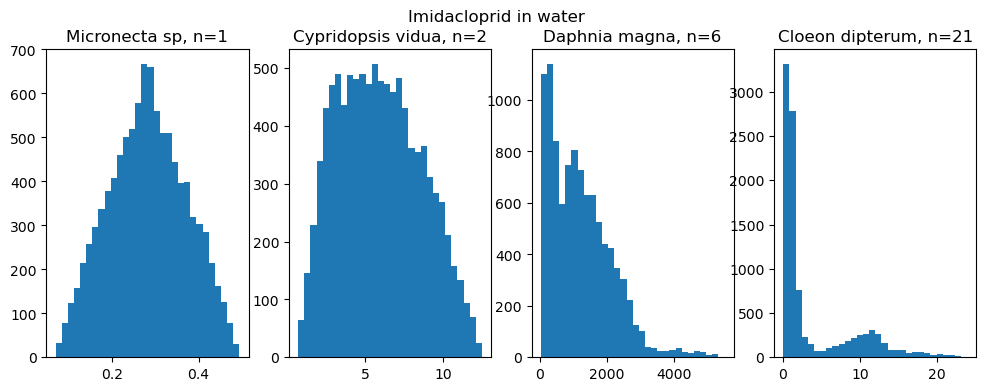

In [144]:
# Pick some species to plot
species = ['Micronecta sp', 'Cypridopsis vidua', 'Daphnia magna', 'Cloeon dipterum']

# Create the graph
fig, axs = plt.subplots(1, len(species), figsize=(12,4))
fig.suptitle('Imidacloprid in water')

# Loop through the species and plot a histogram for each
for i, sp in enumerate(species):
    vals = df_ssd[(df_ssd['compartment'] == 'water') &
                  (df_ssd['chemical'] == 'Imidacloprid') &
                  (df_ssd['species'] == sp)]['tox_value'].values
    axs[i].hist(vals, bins=30)
    axs[i].set_title(f'{sp}, n={n_vals["water"]["Imidacloprid"][sp]}')

## Constructing the PSSD

We now use the full dataset of samples (10,000 * n_species) to construct the full PSSD curve, which is simply the cumulative distribution function (CDF) of all of these values:

In [145]:
# Create a CDF from the tox values
for comp, chemicals in species_by_chemical.items():
    for chem_name, species in chemicals.items():
        df_ = df_ssd[(df_ssd['compartment'] == comp) & (df_ssd['chemical'] == chem_name)]
        # Calculate the CDF and save to a new column
        df_ssd.loc[(df_ssd['compartment'] == comp) &
                   (df_ssd['chemical'] == chem_name),
                   'CDF'] = 1. * np.arange(len(df_)) / (len(df_) - 1)

### Extracting the distribution metrics (Q and mean values)

Now get the Q values and means by grouping by chemical and species. We also need to calculate a CDF for the mean values so we can add them as reference values to the plots.

In [146]:
# Calculate the mean of each SSD
df_ssd_mean = df_ssd.groupby(['compartment', 'chemical', 'species'])['tox_value'].agg(mean='mean',
                                                                                      min='min',
                                                                                      max='max',
                                                                                      q5=lambda x: x.quantile(0.05),
                                                                                      q95=lambda x: x.quantile(0.95),
                                                                                      q25=lambda x: x.quantile(0.25),
                                                                                      q75=lambda x: x.quantile(0.75))
# Sort so that the tox_value is ascending - this is needed to calculate the CDF
df_ssd_mean = df_ssd_mean.sort_values(['compartment', 'chemical', 'mean'])
# Calculate the number of species for each compartment and chemical
n_species_gb = df_ssd_mean.groupby(['compartment', 'chemical'])['mean'].count()

# Loop over compartments and chemicals
for comp, chemicals in species_by_chemical.items():
    for chem_name, species in chemicals.items():
        n_species = n_species_gb[comp, chem_name]
        # Calculate the CDF and save to a new column
        df_ssd_mean.loc[(comp, chem_name, slice(None)), 'mean_CDF'] = 1. * np.arange(n_species) / (n_species - 1)
        
df_ssd_mean

mean         min  \
compartment chemical species                                             
soil        Cadmium  Caenorhabditis elegans       0.116275    0.028396   
                     Gallus gallus domesticus     5.647202    1.327748   
                     Folsomia candida            11.527711    0.375609   
                     Eisenia foetida             14.346859    1.020479   
                     Colinus virginiansus        17.436894    4.195837   
...                                                    ...         ...   
water       Zinc     Ephemerella sp.            688.534062  167.391774   
                     Chloroperlidae             688.832972  163.559255   
                     Opercularia minima         848.185676  198.758816   
                     Rana catesbeiana          1002.133522  255.715331   
                     Cichlasoma managuense     1250.217874  294.885372   

                                                       max          q5  \
compartment chemical species                                             
soil        Cadmium  Caenorhabditis elegans       0.203797    0.055134   
                     Gallus gallus domesticus     9.921322    2.633021   
                     Folsomia candida            67.690134    3.589740   
                     Eisenia foetida             32.424401    3.537786   
                     Colinus virginiansus        30.461321    8.251674   
...                                                    ...         ...   
water       Zinc     Ephemerella sp.           1209.303422  325.923591   
                     Chloroperlidae            1212.775360  321.287734   
                     Opercularia minima        1493.809833  401.854065   
                     Rana catesbeiana          1760.118789  478.197591   
                     Cichlasoma managuense     2178.234332  589.930553   

                                                       q95         q25  \
compartment chemical species                                             
soil        Cadmium  Caenorhabditis elegans       0.177269    0.089866   
                     Gallus gallus domesticus     8.679170    4.374058   
                     Folsomia candida            24.953196    8.094182   
                     Eisenia foetida             27.086910    8.217830   
                     Colinus virginiansus        26.514451   13.470068   
...                                                    ...         ...   
water       Zinc     Ephemerella sp.           1047.037023  534.002790   
                     Chloroperlidae            1052.021449  534.860472   
                     Opercularia minima        1284.785533  659.168472   
                     Rana catesbeiana          1524.846799  776.687682   
                     Cichlasoma managuense     1899.844892  968.734380   

                                                       q75  mean_CDF  
compartment chemical species                                          
soil        Cadmium  Caenorhabditis elegans       0.142787  0.000000  
                     Gallus gallus domesticus     6.932279  0.250000  
                     Folsomia candida            12.821512  0.500000  
                     Eisenia foetida             19.795117  0.750000  
                     Colinus virginiansus        21.434191  1.000000  
...                                                    ...       ...  
water       Zinc     Ephemerella sp.            843.731517  0.955556  
                     Chloroperlidae             844.492868  0.966667  
                     Opercularia minima        1035.433906  0.977778  
                     Rana catesbeiana          1233.154725  0.988889  
                     Cichlasoma managuense     1536.935216  1.000000  

[542 rows x 8 columns]

### Calculating the PNEC distributions

We now use the 5th percentile of each of the 10,000 SSDs to construct a PNEC distribution:

In [147]:
df_hc5 = df_ssd.groupby(['compartment', 'chemical', 'iteration'], as_index=False)['tox_value'].quantile(0.05)
# We create a column saying that these are PNEC values, which will
# be useful when we concat this dataframe with MEC samples later
df_hc5['endpoint'] = 'PNEC'

### Plotting the PSSDs

We can plot a CDF of the PSSDs, annotating with the species-specific means. It is worth noting that the PSSDs are based on the full dataset (i.e. all 10,000 samples of each species), and therefore the *y* values of the CDF are not necessarily in species order. The mean values are grouped by species and shown in order of decreasing sensitivity on the *y* axis for reference only.

In [155]:
from matplotlib import colors
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Create the widgets for the dropdowns and buttons
name_w = widgets.Dropdown(options=species_by_chemical['water'].keys(),
                          value=list(species_by_chemical['water'].keys())[0],
                          description='Chemical:')
c_w = widgets.ToggleButtons(options=compartments,
                            description='Compartment:',
                            value='water')
# Update the dropdown options when we change the compartment
def update(*args):
  name_w.options = species_by_chemical[c_w.value].keys()
c_w.observe(update)

# Styling options
axis_fontsize = 13
species_fontsize = 8
legend_fontsize = 9
colors = plt.cm.tab10.colors
# Colours and markers for the different species, set manually
# to be clearer than the default iteration through symbols
cmap = {
    'Algae': (colors[0], '>'),
    'Amphibian': (colors[1], 'v'),
    'Crustaceans': (colors[2], 's'),
    'Fish': (colors[3], '^'),
    'Insects': (colors[4], 'o'),
    'Rotifera': (colors[6], '<'),
    'Molluscs': (colors[5], 'p'),
    'Nematoda': (colors[7], 'P'),
    'Annelida': (colors[8], '*'),
    'Ciliophora': (colors[9], 'X'),
    'Bryozoa': ('darkgray', 'D'),
    'Platyhelminthes': ('white', '2'),
    'Cnidaria': ('black', 'h'),
    'Chlorophyta': ('lightyellow', '8'),
    'Platyhelminth': ('black', '1')
}
legend_elements = [Line2D([0], [0], marker=v[1], color='w', markerfacecolor=v[0], ms=8, label=k) for k, v in cmap.items()]

# Declare a function that is run each time the dropdown menu is changed
@interact(name=name_w, c=c_w)
def plot_CDF(name, c, condensed=False, savefig=False):
    # Set the sizing based on whether this is a condensed or larger plot
    figsize = (6,6) if condensed else (14,14)
    # Filter the mean, full and HC5 dfs to this chemical
    df_ = df_ssd[(df_ssd['compartment'] == c) & (df_ssd['chemical'] == name)]
    df_mean_ = df_ssd_mean.loc[(c, name, slice(None)),:]
    df_hc5_ = df_hc5[(df_hc5['compartment'] == c) & (df_hc5['chemical'] == name)]
    # Plot the PSSD and means of each species
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xscale('log')
    df_.plot('tox_value', 'CDF', ax=ax, lw=4, color='darkgreen', legend=None, zorder=5)
    # Get info about the species to use in the plots
    n_species = len(df_mean_.index.get_level_values(2))
    height = 1 / n_species
    rescale_y = 1 - height
    rect_args = {'height': height, 'alpha': 0.15, 'color': 'green', 'lw': 0}
    y_range = df_['tox_value'].max() - df_['tox_value'].min()
    if c == 'water':
        water_taxa = df_tox['water'][(df_tox[c]['Chemical'] == name)]['Taxa'].drop_duplicates().values
    # Add the distribution boxes for each species
    for index, row in df_mean_.iterrows():
        if c == 'water':
            # Taxa
            taxa = df_tox[c][(df_tox[c]['Chemical'] == name) & (df_tox[c]['Species'] == index[2])]['Taxa'].values[0]
            i_taxa = s_taxa[c][s_taxa[c] == taxa].index.values[0]
            color=cmap[taxa][0]
            marker=cmap[taxa][1]
        else:
            color='darkblue'
            marker='o'
        # color = 'black'
        # Add the species name
        ax.annotate(index[2], (row['max'] + (row['max'] / 5), row['mean_CDF'] * rescale_y + height / 2),
                    horizontalalignment='left', verticalalignment='center', style='italic',
                    path_effects=[pe.withStroke(linewidth=4, foreground='white')], fontsize=species_fontsize,
                    zorder=6)
        # Add the min-max, Q5-95 and Q25-75 boxes
        ax.add_patch(Rectangle((row['min'], row['mean_CDF'] * rescale_y), width=row['max'] - row['min'], zorder=1, **rect_args))
        ax.add_patch(Rectangle((row['q5'], row['mean_CDF'] * rescale_y), width=row['q95'] - row['q5'], zorder=2, **rect_args))
        ax.add_patch(Rectangle((row['q25'], row['mean_CDF'] * rescale_y), width=row['q75'] - row['q25'], zorder=3, **rect_args))
        # Get the original data values
        tox_values = df_tox[c][(df_tox[c]['Chemical'] == name) & (df_tox[c]['Species'] == index[2])]['tox_conv']
        ax.scatter(x=tox_values, y=[row['mean_CDF'] * rescale_y + height / 2] * len(tox_values), color=color, marker=marker,
                  zorder=4)
    # Some more styling
    ax.set_xlabel(f'NOEC ({units[c]})', fontsize=axis_fontsize)
    ax.set_ylabel('Proportion of species affected', fontsize=axis_fontsize)
    ax.grid(True, color='lightgray', zorder=0)
    # Add another legend for the PSSD
    legend_handles = [
        Line2D([0], [0], color='darkgreen', label='PSSD', lw=3),
        Patch(facecolor='green', alpha=0.15, label='Min to max'),
        Patch(facecolor='green', alpha=0.3, label='Q5 to Q95'),
        Patch(facecolor='green', alpha=0.45, label='Q25 to Q75')
    ]
    if c == 'water':
        legend_handles.extend([e for e in legend_elements if e.get_label() in water_taxa])    
    ax.legend(handles=legend_handles, loc='upper left', fontsize=legend_fontsize)

    # Add the PNEC graph
    axis_params = [0.7, 0.19, 0.2, 0.2] if condensed else [0.13, 0.45, 0.15, 0.15]
    ax2 = fig.add_axes(axis_params)
    ax2.hist(df_hc5_['tox_value'], bins=20, edgecolor='w', linewidth=1, facecolor='slategrey')
    ax2.set_yticks([])
    ax2.set_ylabel('Probability density', fontsize=9)
    if not condensed:
        ax2.yaxis.set_label_position('right')
    ax2.set_xlabel(f'PNEC ({units[c]})', fontsize=9)
    ax2.tick_params('x', labelsize=8)
    
    if savefig:
        filename = f'../figures/{c}_{name}'
        filename = f'{filename}_condensed.png' if condensed else f'{filename}.png'
        ax.set_title(f'{name} in {c}')
        fig.savefig(filename, dpi=400, bbox_inches='tight')

interactive(children=(Dropdown(description='Chemical:', options=('Arsenic', 'Zinc', 'Manganese', 'Cadmium', 'I…

Extract mean HC5 value for imidacloprid in water:

In [149]:
df_hc5_ = df_hc5[(df_hc5['compartment'] == 'water') & (df_hc5['chemical'] == 'Imidacloprid')]
print(f'Mean HC5: {df_hc5_["tox_value"].mean()}')
print(f'Max HC5: {df_hc5_["tox_value"].max()}')

Mean HC5: 0.02286192517671757
Max HC5: 0.03799265331717139


We can use the `plot_CDF` function that we just created to save the figures we want for the publication (and SI):

## Calculate MEC distributions and CDFs

We now use the measured environmental concentration (MEC) data to calculate distributions of environmental concentrations by fitting lognormal distributions. This simple approach is used as anything more complex risks overfitting our data (e.g., using kernel density fits might result in erroneously bimodal distributions). We then calculate CDFs of both the PNEC and MEC distributions and store in one big dataframe alongside the PSSDs, ready for plotting against each other. The also creates a dataframe of sampled values, containing HC5 and MEC samples.

In [150]:
dists = []
values = []

# Loop through the compartments and chemicals
for comp, chemicals in species_by_chemical.items():
    # Store the df for this compartment, for convenience
    df = df_mec[comp]
    for chem_name, species in chemicals.items():
        # Get the measured concentrations
        log_mec_values = np.log(df[df['chemical'] == chem_name]['MEC'].values)
        # Define an x grid
        sample_range = log_mec_values.max() - log_mec_values.min()
        x_mec = np.linspace(log_mec_values.min() - 0.75 * sample_range,
                             log_mec_values.max() + 0.75 * sample_range, 1000)

        # Fit a lognormal distribution to the concs and get the PDF and CDF,
        # un-logging the data and normalizing as we go
        mean, std = stats.norm.fit(log_mec_values)
        mec_sample = np.exp(stats.norm.rvs(mean, std, size=1000))
        
        # Generate the MEC PDF and CDF
        mec_pdf = stats.norm.pdf(x_mec, mean, std)
        mec_pdf = mec_pdf / mec_pdf.max()
        mec_cdf = stats.norm.cdf(x_mec, mean, std)
        mec_cdf = mec_cdf / mec_cdf.max()
        x_mec = np.exp(x_mec)
        
        # Get the PNEC distribution data points and calculate the CDF
        pnec_values = df_hc5[(df_hc5['compartment'] == comp) & (df_hc5['chemical'] == chem_name)]['tox_value'].values
        x_pnec = np.sort(pnec_values)
        pnec_cdf = np.arange(len(pnec_values)) / (len(pnec_values) - 1)
        
        # Get the PSSD distribution CDF
        pssd_cdf = df_ssd[(df_ssd['compartment'] == comp) & (df_ssd['chemical'] == chem_name)]['CDF'].values
        x_pssd = df_ssd[(df_ssd['compartment'] == comp) & (df_ssd['chemical'] == chem_name)]['tox_value'].values
        
        # Downsample the DFs to 1000 data points to speed up plotting
        cdf_ds = np.linspace(0, 1, 1000)
        f_pnec_cdf = interpolate.interp1d(pnec_cdf, x_pnec)
        f_pssd_cdf = interpolate.interp1d(pssd_cdf, x_pssd)
        x_pnec_ds = f_pnec_cdf(cdf_ds)
        x_pssd_ds = f_pssd_cdf(cdf_ds)
        
        # Add MECs and PNECs to the dataframe
        for i, x in enumerate(x_mec):
            dists.append({
                'compartment': comp,
                'chemical': chem_name,
                'conc': x,
                'pdf': mec_pdf[i],
                'cdf': mec_cdf[i],
                'endpoint': 'MEC'
            })
        for i, x in enumerate(x_pnec_ds):
            dists.append({
                'compartment': comp,
                'chemical': chem_name,
                'conc': x,
                'cdf': cdf_ds[i],
                'endpoint': 'PNEC'
            })
        for i, x in enumerate(x_pssd_ds):
            dists.append({
                'compartment': comp,
                'chemical': chem_name,
                'conc': x,
                'cdf': cdf_ds[i],
                'endpoint': 'PSSD'
            })
            values.append({
                'compartment': comp,
                'chemical': chem_name,
                'conc': x,
                'endpoint': 'PSSD'
            })
        for i, v in enumerate(mec_sample):
            values.append({
                'compartment': comp,
                'chemical': chem_name,
                'conc': v,
                'endpoint': 'MEC'
            })

# Save these generated values to dataframes
df_dists = pd.DataFrame(dists)
df_mec_samples = pd.DataFrame(values)
df_values = pd.concat([df_hc5.rename(columns={'tox_value': 'conc'}).drop(columns='iteration'), df_mec_samples])

## Plot MEC-PSSD distributions

We can now plot the MEC distributions we just calculated against the PSSDs (or PNEC distributions).

In [151]:
c_w = widgets.ToggleButtons(options=compartments,
                            description='Compartment:',
                            value='water')

# Declare a function that is run each time the dropdown menu is changed
@interact(c=c_w)
def plot_dists(c):
    height = 900 if c == 'water' else 440
    row_spacing = 0.04 if c == 'water' else 0.1
    fig = px.line(df_dists[(df_dists['compartment'] == c) &
                           ((df_dists['endpoint'] == 'MEC') | (df_dists['endpoint'] == 'PSSD'))],
                  x='conc', y='cdf', color='endpoint', facet_col='chemical', facet_col_wrap=4, log_x=True,
                  width=1000, height=height, facet_row_spacing=row_spacing, facet_col_spacing=0.02, color_discrete_map={'PSSD': 'darkgreen', 'MEC': 'blue'},
                  template='plotly_white', labels={'endpoint': ''})
    fig.for_each_annotation(lambda a: a.update(text=a.text.split('=')[-1]))
    fig.for_each_yaxis(lambda y: y.update(title=''))
    fig.for_each_xaxis(lambda x: x.update(title=''))
    fig.add_annotation(x=-0.07, y=0.5, text='Cumulative probability', textangle=-90, xref='paper', yref='paper', showarrow=False, font_size=16)
    fig.add_annotation(y=-0.07, x=0.5, text=f'Concentration ({units["water"]})', xref='paper', yref='paper', showarrow=False, font_size=16)
    fig.update_xaxes(exponentformat='power', range=[-5, 6] if c=='water' else None)
    fig.update_yaxes(range=[-0.01, 1.02])
    fig.show()

interactive(children=(ToggleButtons(description='Compartment:', options=('water', 'soil'), value='water'), Out…

## Calculating risk

We will use the method proposed in [Gottschalk and Nowack, 2012](https://doi.org/10.1002/ieam.1334) to predict risk. This calculates the product of the fraction of critical tox values (those that are less than the maximum value from the MEC distribution) and the fraction of critical MEC distribution values (those that are greater than the minimum value from the PSSD):

$$
\text{Risk} = \frac{\text{MEC}_\text{values} \geq \text{LC50}_\text{min}}{\text{MEC}_\text{values}} \cdot \frac{\text{LC50}_\text{values} \leq \text{MEC}_\text{max}}{\text{LC50}_\text{values}}
$$

If risk is 1 (100%), then the entire distributions overlap. If risk is 0, the distributions don't overlap at all.

/tmp/ipykernel_14978/3893251318.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



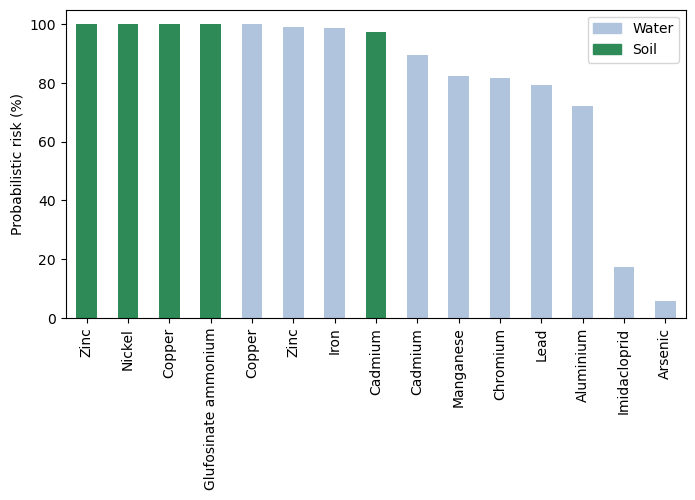

In [152]:
df_risk = pd.DataFrame({})

# Loop through the compartments and chemicals
for comp, chemicals in species_by_chemical.items():
  # Empty dataframe to store risk values in
  df_risk_ = pd.DataFrame({'chemical': chemicals.keys(),
                          'risk': np.empty(len(chemicals)),
                          'mean_err': np.empty(len(chemicals)),
                          'compartment': comp})
  # Loop over the chemicals
  for chem_name, species in chemicals.items():
    # Filter the dataframe just for this chemical
    df_ = df_dists[(df_dists['compartment'] == comp) & (df_dists['chemical'] == chem_name)].reset_index()
    # Get the MEC and PSSD rows
    df_mec = df_[df_['endpoint'] == 'MEC']
    df_pssd = df_[df_['endpoint'] == 'PSSD']
    # Get the PSSD value at the maximum MEC value, which we define
    # as the MEC CDF value closest to 0.999. First, get the row index
    # at this location
    i_mec_mecmax = df_mec['cdf'].sub(0.999).abs().idxmin()
    # Then get the MEC concentration at this index
    conc_mecmax = df_mec.loc[i_mec_mecmax]['conc']
    # Get the index of the PSSD df row where the conc is closest to this
    i_pssd_mecmax = df_pssd['conc'].sub(conc_mecmax).abs().idxmin()
    # Then get the CDF value at this index
    pssd_at_mecmax = df_pssd.loc[i_pssd_mecmax]['cdf']
    # Repeat but this time getting the MEC CDF value at the minimum (0.001)
    # PSSD value
    i_pssd_pssdmin = df_pssd['cdf'].sub(0.001).abs().idxmin()
    conc_pssdmin = df_pssd.loc[i_pssd_pssdmin]['conc']
    i_mec_pssdmin = df_mec['conc'].sub(conc_pssdmin).abs().idxmin()
    mec_at_pssdmin = df_mec.loc[i_mec_pssdmin]['cdf']
    # Calculate risk as the product of these
    risk = ((1 - mec_at_pssdmin) * pssd_at_mecmax) * 100
    # Calculate the mean error so that we can rank the chemicals that have
    # the same risk
    mean_err = df_mec['conc'].mean() - df_pssd['conc'].mean()
    # Add to our dataframe
    df_risk_.loc[df_risk_['chemical'] == chem_name, 'risk'] = risk
    df_risk_.loc[df_risk_['chemical'] == chem_name, 'mean_err'] = mean_err
    
  # Combine water and soil into one df  
  df_risk = pd.concat([df_risk, df_risk_])
    
# Sort by risk and plot
df_risk = df_risk.sort_values(['risk', 'mean_err'], ascending=False)
df_risk['color'] = 'seagreen'
df_risk.loc[:, 'color'][df_risk['compartment'] == 'water'] = 'lightsteelblue'

fig, ax = plt.subplots(figsize=(8,4))
ax = df_risk.plot.bar(x='chemical', y='risk', color=df_risk['color'], ax=ax)
ax.legend(handles=[Patch(color=c, label=l) for l, c in {'Water': 'lightsteelblue', 'Soil': 'seagreen'}.items()])
ax.set_xlabel('')
ax.set_ylabel('Probabilistic risk (%)')

fig.savefig('../figures/risk-ranking.png', dpi=400, bbox_inches='tight')

## Publication-friendly PSSD-MEC plots

Now we will recreate the PSSD-MEC comparison plots from above, but tidying them up to be a little more publication-friendly. We will also use the risk ranking to plot them in risk order, hence we are doing this after the risk ranking.

In [1]:
# Settings
title_fontsize = 9

# Define the function to plot the PSSD-MEC comparisons for one compartment
def plot_pssd_mec(comp):
    # Set some useful variables
    chemicals = df_risk[df_risk['compartment'] == comp]['chemical']
    n_chemicals = len(chemicals)
    n_subplots_final_row = n_chemicals % 4
    n_rows = n_chemicals // 4 + 1
    plot_height = n_rows * 1.75

    # Create the plot with the correct number of facets
    fig, axs = plt.subplots(n_rows, 4, sharex=True, sharey=True, figsize=(8, plot_height))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i in range(n_subplots_final_row, 4):
        axs[-1][i].set_axis_off()

    # Loop over the axes/facets
    for i, ax in enumerate(axs.flatten()):
        if i < n_chemicals:
            # Get the data for this chemical
            chem = df_risk[df_risk['compartment'] == comp].iloc[i]['chemical']
            df_pssd = df_dists[((df_dists['compartment'] == comp) &
                                (df_dists['chemical'] == chem) &
                                (df_dists['endpoint'] == 'PSSD'))]
            df_mec = df_dists[((df_dists['compartment'] == comp) &
                                (df_dists['chemical'] == chem) &
                                (df_dists['endpoint'] == 'MEC'))]
            # Plot the data
            ax.plot(df_pssd['conc'], df_pssd['cdf'], c='darkgreen', lw=2, zorder=2)
            ax.plot(df_mec['conc'], df_mec['cdf'], lw=2, zorder=1)
            ax.set_title(chem, fontsize=title_fontsize, y=1.0, pad=-14, path_effects=[pe.withStroke(linewidth=4, foreground='white')])
            # Add the grey band representing the HC5 distribution
            hc5_min = df_hc5[(df_hc5['compartment'] == comp) & (df_hc5['chemical'] == chem)]['tox_value'].min()
            hc5_max = df_hc5[(df_hc5['compartment'] == comp) & (df_hc5['chemical'] == chem)]['tox_value'].max()
            ax.add_patch(Rectangle((hc5_min, -0.05), width=hc5_max - hc5_min, zorder=0, height=1.1, facecolor='lightgray'))

            # Scale and axes
            ax.set_xscale('log')
            ax.set_ylim(-0.05, 1.05)
            ax.set_yticks([])
            if i > n_chemicals - n_subplots_final_row - 3:
                ax.xaxis.set_tick_params(which='both', labelbottom=True)

    # Create the handles for the legend and add the legend
    legend_handles = [
        Line2D([0], [0], color='darkgreen', label='PSSD', lw=2),
        Line2D([0], [0], label='MEC', lw=2),
        Patch(facecolor='lightgray', label='PNEC distribution range'),
    ]
    fig.legend(handles=legend_handles,
               bbox_to_anchor=(0.58 if comp == 'water' else 0.35,
                               0.3 if comp == 'soil' else 0.22),
               loc='center left',
               ncol=1 if comp == 'water' else 3)
    # Final styling and saving the figure
    fig.supylabel('Cumulative probability', x=0.09)
    fig.supxlabel(f'Concentration ({units[comp]})')
    fig.suptitle(comp.capitalize(), y=0.96 if comp == 'soil' else 0.925)
    fig.savefig(f'../figures/{comp}_MEC-PSSD.png', dpi=400, bbox_inches='tight')
    
plot_pssd_mec('water')
plot_pssd_mec('soil')

NameError: name 'df_risk' is not defined